In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations

# Loading data

In [2]:
df_pro_contacts_adults = pd.read_csv("pro_contacts_adults.csv", index_col=0)
df_pro_contacts_children = pd.read_csv("pro_contacts_children.csv", index_col=0)
df_households = pd.read_csv("households.csv", index_col=0)


#infos
print(df_households.sum())
#df_households.describe()
#df_pro_contacts_children.describe()
#df_pro_contacts_adults.describe()




nb_children                                                 3085
nb_adults                                                   6960
type           two_parent_familytwo_parent_familytwo_parent_f...
size                                                       10045
dtype: object


# Initializing the graph

We start by defining the classes whose instances will be the nodes of our graph

In [3]:
class Person():
    def __init__(self, person_id, state, age):
        self.person_id = person_id
        self.age = age
        self.state = state
    def info(self):
        infos = "{} {} {}".format(self.age,self.person_id, self.state)
    
    def __str__(self):
        s = "Person #{}".format(self.person_id)
        return(s)
    
    def __repr__(self):
        s = "Person #{}".format(self.person_id)
        return(s)

class Adult(Person):
    def __init__(self, person_id, state, job_cat, pro_contacts, company_id):
        super().__init__(person_id, state, "adult")
        self.job_cat = job_cat
        self.working = True #will change during confinement
        self.pro_contacts = pro_contacts
        self.company_id = company_id
    def info(self):
        infos = "{} {} {}".format(self.age,self.person_id, self.state)

class Child(Person):
    def __init__(self, person_id, state, school_contacts, school_id):
        super().__init__(person_id, state, "child")
        self.job_cat = job_cat
        self.school_contacts = school_contacts
        self.school_id = school_id
    def info(self):
        infos = "{} {} {}".format(self.age,self.person_id, self.state)

We create an empty graph into which we add nodes from the pro_contacts dataframes.

In [4]:
G = nx.Graph()
people = [] # we'll store Person objects here too in order to be able to access them quickly with person_id

for i, row in df_pro_contacts_adults.iterrows(): #We add adults to the nodes
    person_id = row.adult_id
    state = "S"
    job_cat = row.job_cat
    pro_contacts = row.pro_contacts
    company_id = row.company_id
    
    adult_node = Adult(person_id, state, job_cat, pro_contacts, company_id)
    G.add_node(adult_node)
    people.append(adult_node)
    
for i, row in df_pro_contacts_children.iterrows(): #We add childrens to the nodes
    person_id = row.child_id
    state = "S"
    school_contacts = row.school_contacts
    school_id = row.school_id
    
    child_node = Child(person_id, state, school_contacts, school_id)
    G.add_node(child_node)
    people.append(child_node)

    #print(G.nodes())
    


# Creating cliques for households

In [5]:
n_households = max(max(df_pro_contacts_children.index), max(df_pro_contacts_adults.index))
for id_household in range(n_households):
    df_household_adults = df_pro_contacts_adults.loc[df_pro_contacts_adults.index == id_household]
    household_adults = df_household_adults.adult_id
    
    df_household_children = df_pro_contacts_children.loc[df_pro_contacts_children.index == id_household]
    household_children = df_household_children.child_id
    
    household_people_ids = list(household_children) + list(household_adults)
    for edge in combinations(household_people_ids, 2):
        a = people[edge[0]]
        b = people[edge[1]]
        G.add_edge(a, b)
        G[a][b]["type"] = "household"
        G[a][b]["id"] = id_household
        



In [6]:
if (False):
    #pos = nx.spring_layout(G, iterations=20)
    nx.draw_networkx_nodes(G,pos,node_size=30 ,alpha =0.3)
    nx.draw_networkx_edges(G, pos)
    

# Creating cliques for companies

In [7]:
n_companies = int(max(df_pro_contacts_adults.company_id))
for company_id in range(n_companies):
    df_company = df_pro_contacts_adults.loc[df_pro_contacts_adults.company_id == company_id]
    company_employees_ids = list(df_company.adult_id)
    
    for edge in combinations(company_employees_ids, 2):
        a = people[edge[0]]
        b = people[edge[1]]
        G.add_edge(a, b)
        G[a][b]["type"] = "company"
        G[a][b]["id"] = company_id

In [8]:
df_company

,adult_id,job_cat,pro_contacts,company_id
household_id,,,,
1087,2699,Services_other,1317,250.0
1619,4024,Services_other,201,250.0
2458,5009,Services_other,714,250.0


In [9]:
#calcule la position des nodes pour afficher le graph 
# /!\ très lent /!\
pos = nx.spring_layout(G, iterations=1)




C:\Users\nicol\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\nicol\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \


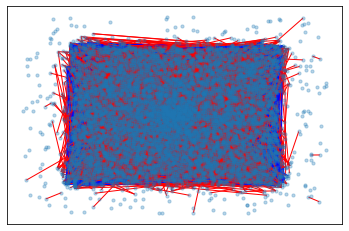

In [10]:
edge_color = []
for edge in G.edges():
    #print(edge)
    edge = G[edge[0]][edge[1]]
    if edge["type"] == "company":
        edge_color.append("b")
    if edge["type"] == "household":
        edge_color.append("r")
    

nx.draw_networkx_nodes(G,pos,node_size=10 ,alpha =0.3)
nx.draw_networkx_edges(G, pos,edge_color = edge_color)

# Adding links for pro life outside the company

In [11]:
for i, row in df_pro_contacts_adults.iterrows():
    adult_id = row.adult_id
    job_cat = row.job_cat
    pro_contacts = row.pro_contacts
    company_id = row.company_id
    
    company_employees_ids = list(df_pro_contacts_adults.loc[(df_pro_contacts_adults.company_id == company_id) &\
                                                            (df_pro_contacts_adults.adult_id != adult_id)].adult_id)

    #TO DO
        
for i, row in df_pro_contacts_children.iterrows():
    child_id = row.child_id
    school_contacts = row.school_contacts
    school_id = row.school_id
    
#     scool_pupils_ids = list(df_pro_contacts_children.loc[(df_pro_contacts_children.school_id == school_id) & (df_pro_contacts_adults.adult_id != adult_id)].adult_id)
    # TO DO

In [12]:
df_pro_contacts_adults.loc[(df_pro_contacts_adults.company_id == company_id)]

,adult_id,job_cat,pro_contacts,company_id
household_id,,,,
506,1245,Shops_other,9,101.0
745,1829,Services_other,998,101.0
1844,4395,Shops_other,4,101.0
3775,6933,Shops_other,13,101.0
3801,6959,Services_other,870,101.0


In [13]:
pro_contacts

870

# Exporting the graph for visualization with Gephi

In [14]:
nx.write_gexf(G, "test.gexf")

# Modeling Coronavirus behaviour without any action taken

### illness duration
https://www.thelancet.com/journals/lancet/article/PIIS0140-6736(20)30566-3/fulltext#seccestitle150 in this paper we see that in average an infected personne has symptomes for 20 days (worst and best being 8 days and 37 days). This is more or less independent of the fact that the individual recovers or die after thos 20 days. I will thus use this to calculate the half-life of the infected state. 

### infection probability
the R0 is given at 2.5. we calculate the probability of infecting a neighbor node using this and the mean duration of the infected state of 20 days. 




In [15]:
import numpy as np
# infected state duration and evolution
mean_sickness_duration = 20
half_life = mean_sickness_duration * np.log(2) 
daily_proba_change = 1 - (1/2)**(1/half_life) 

child_mortality = 0.002
adult_mortality = 0.02

child_recovery = 1- child_mortality
adult_recovery = 1- adult_mortality

mean_degree = len(G.edges) * 2 /len(G.nodes)
print(mean_degree)

#infection probability for each link daily
R0 = 2.5 
daily_infection_proba = R0 / mean_sickness_duration


26.066102538576406


#  Economic impact

We gauge economic impact by counting the number of people who cannot work daily 
pondered by the importance of their activity sector. We choose to follow this communiqué to get the sectors importance https://moodle.imt-atlantique.fr/mod/url/view.php?id=18312

We choose the crutial categories like Health and food whitch cannot be in lockdown.
For the others we use the estimate of how much remote work is possible.

All classes have a PIB weight value. It represents how much its function contribute to the PIB. 


In [16]:
#df_pro_contacts_adults.groupby("job_cat").mean()


In [17]:

class Job_category():
    
    def __init__(self,job_cat, category,remote_work_possibility, remote_work, PIB_weight):
        self.job_cat = job_cat # name in the dataframe
        self.category =category #equivalent in the communiqué
        self.remote_work_possibility = remote_work_possibility #false for health and agriculture
        self.remote_work = remote_work #percentage of remote work efficiency 
        self.PIB_weight = PIB_weight #found in the communiqué


job_info = dict()
job_info['Administration_schools'] = Job_category(job_cat = 'Administration_schools',
                                                  category = 'Services non marchands',
                                                  remote_work_possibility = True,
                                                  remote_work = 1 - 0.14,
                                                  PIB_weight = 0.22)

job_info['Agriculture_fishing'] = Job_category(job_cat = 'Agriculture_fishing',
                                                  category = 'Services non marchands',
                                                  remote_work_possibility = False,
                                                  remote_work = 1 - 0.98,
                                                  PIB_weight = 0.04)

job_info['Construction'] = Job_category(job_cat = 'Construction',
                                                  category = 'Construction non marchands',
                                                  remote_work_possibility = True,
                                                  remote_work = 1 - 0.89,
                                                  PIB_weight = 0.06)

job_info['Health'] = Job_category(job_cat = 'Health',
                                                  category = 'Health',
                                                  remote_work_possibility = False,
                                                  remote_work = 1 - 0.5,
                                                  PIB_weight = 0.22)

job_info['Hotel_Restaurant'] = Job_category(job_cat = 'Hotel_Restaurant',
                                                  category = 'Services marchands',
                                                  remote_work_possibility = True,
                                                  remote_work = 1 - 0.98,
                                                  PIB_weight = 0.56)

job_info['Indus_food'] = Job_category(job_cat = 'Indus_food',
                                                  category = 'Agriculture et industries agro-alimentaires',
                                                  remote_work_possibility = False,
                                                  remote_work = 1 - 0.80,
                                                  PIB_weight = 0.04)
job_info['Indus_other'] = Job_category(job_cat = 'Indus_other',
                                                  category = 'Industrie hors agro-alimentaire',
                                                  remote_work_possibility = True,
                                                  remote_work = 1 - 0.52,
                                                  PIB_weight = 0.12)

job_info['Services_other'] = Job_category(job_cat = 'Services_other',
                                                  category = 'Services non marchands',
                                                  remote_work_possibility = True,
                                                  remote_work = 1 - 0.14,
                                                  PIB_weight = 0.22)

job_info['Shops_market_food'] = Job_category(job_cat = 'Shops_market_food',
                                                  category = 'Agriculture et industries agro-alimentaires',
                                                  remote_work_possibility = False,
                                                  remote_work = 1 - 0.98,
                                                  PIB_weight = 0.04)
job_info['Shops_other'] = Job_category(job_cat = 'Shops_other',
                                                  category = 'Services marchands',
                                                  remote_work_possibility = True,
                                                  remote_work = 1 - 0.36,
                                                  PIB_weight = 0.56)
job_info['Transportation'] = Job_category(job_cat = 'Transportation',
                                                  category = 'Transportation',
                                                  remote_work_possibility = False,
                                                  remote_work = 1 - 0.36,
                                                  PIB_weight = 0.56)


In [18]:
"""model 1 SIR with permanent recovery nobody change their habits. 
"""
import random 


class Basic_SIR_Model():
    
    def __init__(self,G):
        import random
        self.G = G # This model's graph
        
        self.states =["S" #sane
                ,"I" #infected
                ,"D" #dead
                ,"R"] #recovered
        
        #infetion probabilities are for each interactions everydays 
        #death and recovery proba are for one day
        mean_degree = len(self.G.edges) * 2 /len(self.G.nodes)
        daily_link_infection_proba = daily_infection_proba / mean_degree # this gives R0 = 2.5
        
        self.infection_probas=dict() #probability of infection dependeing on the type of the interaction
        self.infection_probas['company']= daily_link_infection_proba
        self.infection_probas["household"]= daily_link_infection_proba * 1.5 
        # because you spend more time with your family
        
        self.death_proba=dict() #daily proba of death if infected
        self.death_proba["adult"]= daily_proba_change * adult_mortality
        self.death_proba["child"]= daily_proba_change * child_mortality

        self.recovery_proba=dict() #daily proba of recovery if infected
        self.recovery_proba["adult"]= daily_proba_change * adult_recovery
        self.recovery_proba["child"]= daily_proba_change * child_recovery

        #TODO add a self.data = dict to get statistics 

    def initialize_patients_zero(self, number_of_first_cases = 1):
        for node in list(self.G.nodes()): # everybody is sane at the begining 
            node.state = "S"
            if type(node) == Adult:
                node.working = True #at beginning all adults work
        print('first infected are:') 
        for random_pick in random.sample(list(self.G.nodes()), number_of_first_cases): 
            print(random_pick)
            random_pick.state = "I"

    def interaction(self,interaction_type): # return true if there is an infection
        return ( random.random()<=self.infection_probas[interaction_type])

    def sickness_evolution(self,age): # return state of the infected at the end of the day
        r = random.random()
        if r <= self.death_proba[age]:
            return "D"
        if r<= self.recovery_proba[age]:
            return "R"
        else:
            return "I"

    def one_normal_day_passes(self): #update all the graph 
        print("today everybody went to work as usual.")
        changing_state = dict()
        for state in self.states:
            changing_state[state]= []

        for node in list(self.G.nodes()):
            if node.state == "I":  
                #we try each possible infection
                for neig in self.G[node]: 
                    if neig.state == "S":
                        t = self.G[node][neig]['type']
                        if self.interaction(t):
                            changing_state["I"].append(neig) #new infected :'(         
                #we check if the condition of the sick change (death recovery or no change)
                new_state = self.sickness_evolution(node.age) 
                if new_state != node.state : 
                    changing_state[new_state].append(node)                    

        for state in self.states: #update all the nodes states at once after all the interactions
            for node in changing_state[state]:
                node.state = state
                #for now sick people work because this scenario is low-key distopian
                if(state == "D" and type(node) == Adult): 
                    node.working = False #dead people don't work :'(
                    
                
                
        #basic visualisation    kinda bad        
        for state in self.states:
            total =len([nd for nd in list(self.G.nodes) if nd.state == state ])
            print(state,' Total ',total, ' new',len(changing_state[state])," today") 
    
    def basic_scenario(self): 
        self.initialize_patients_zero(number_of_first_cases=5)
        for i in range(365):
            self.one_normal_day_passes()


In [19]:
#We put 5 infected in a untouched country which take no counter-mesure for a year
m = Basic_SIR_Model(G)
m.basic_scenario()

first infected are:
Person #6556
Person #5998
Person #1341
Person #3492
Person #189
today everybody went to work as usual.
S  Total  10039  new 0  today
I  Total  6  new 1  today
D  Total  0  new 0  today
R  Total  0  new 0  today
today everybody went to work as usual.
S  Total  10036  new 0  today
I  Total  9  new 3  today
D  Total  0  new 0  today
R  Total  0  new 0  today
today everybody went to work as usual.
S  Total  10035  new 0  today
I  Total  10  new 1  today
D  Total  0  new 0  today
R  Total  0  new 0  today
today everybody went to work as usual.
S  Total  10029  new 0  today
I  Total  16  new 6  today
D  Total  0  new 0  today
R  Total  0  new 0  today
today everybody went to work as usual.
S  Total  10019  new 0  today
I  Total  25  new 10  today
D  Total  0  new 0  today
R  Total  1  new 1  today
today everybody went to work as usual.
S  Total  10005  new 0  today
I  Total  38  new 18  today
D  Total  1  new 1  today
R  Total  1  new 0  today
today everybody went to work

I  Total  423  new 31  today
D  Total  17  new 1  today
R  Total  336  new 11  today
today everybody went to work as usual.
S  Total  9238  new 0  today
I  Total  441  new 32  today
D  Total  17  new 0  today
R  Total  349  new 13  today
today everybody went to work as usual.
S  Total  9211  new 0  today
I  Total  448  new 30  today
D  Total  19  new 2  today
R  Total  367  new 18  today
today everybody went to work as usual.
S  Total  9180  new 0  today
I  Total  451  new 31  today
D  Total  20  new 1  today
R  Total  394  new 27  today
today everybody went to work as usual.
S  Total  9159  new 0  today
I  Total  452  new 24  today
D  Total  20  new 0  today
R  Total  414  new 20  today
today everybody went to work as usual.
S  Total  9136  new 0  today
I  Total  455  new 23  today
D  Total  20  new 0  today
R  Total  434  new 20  today
today everybody went to work as usual.
S  Total  9112  new 0  today
I  Total  452  new 26  today
D  Total  22  new 2  today
R  Total  459  new 25  tod

I  Total  824  new 41  today
D  Total  63  new 0  today
R  Total  2196  new 43  today
today everybody went to work as usual.
S  Total  6930  new 0  today
I  Total  815  new 33  today
D  Total  63  new 0  today
R  Total  2237  new 41  today
today everybody went to work as usual.
S  Total  6893  new 0  today
I  Total  811  new 39  today
D  Total  63  new 0  today
R  Total  2278  new 41  today
today everybody went to work as usual.
S  Total  6862  new 0  today
I  Total  811  new 31  today
D  Total  63  new 0  today
R  Total  2309  new 31  today
today everybody went to work as usual.
S  Total  6835  new 0  today
I  Total  804  new 29  today
D  Total  64  new 1  today
R  Total  2342  new 33  today
today everybody went to work as usual.
S  Total  6803  new 0  today
I  Total  792  new 34  today
D  Total  64  new 0  today
R  Total  2386  new 44  today
today everybody went to work as usual.
S  Total  6762  new 0  today
I  Total  795  new 41  today
D  Total  65  new 1  today
R  Total  2423  new 

I  Total  248  new 3  today
D  Total  86  new 2  today
R  Total  3749  new 9  today
today everybody went to work as usual.
S  Total  5957  new 0  today
I  Total  239  new 5  today
D  Total  87  new 1  today
R  Total  3762  new 13  today
today everybody went to work as usual.
S  Total  5952  new 0  today
I  Total  232  new 5  today
D  Total  87  new 0  today
R  Total  3774  new 12  today
today everybody went to work as usual.
S  Total  5948  new 0  today
I  Total  222  new 4  today
D  Total  87  new 0  today
R  Total  3788  new 14  today
today everybody went to work as usual.
S  Total  5945  new 0  today
I  Total  213  new 3  today
D  Total  87  new 0  today
R  Total  3800  new 12  today
today everybody went to work as usual.
S  Total  5940  new 0  today
I  Total  206  new 5  today
D  Total  87  new 0  today
R  Total  3812  new 12  today
today everybody went to work as usual.
S  Total  5933  new 0  today
I  Total  199  new 7  today
D  Total  87  new 0  today
R  Total  3826  new 14  toda

I  Total  38  new 0  today
D  Total  95  new 0  today
R  Total  4268  new 5  today
today everybody went to work as usual.
S  Total  5644  new 0  today
I  Total  37  new 0  today
D  Total  95  new 0  today
R  Total  4269  new 1  today
today everybody went to work as usual.
S  Total  5644  new 0  today
I  Total  36  new 0  today
D  Total  95  new 0  today
R  Total  4270  new 1  today
today everybody went to work as usual.
S  Total  5644  new 0  today
I  Total  35  new 0  today
D  Total  95  new 0  today
R  Total  4271  new 1  today
today everybody went to work as usual.
S  Total  5644  new 0  today
I  Total  30  new 0  today
D  Total  95  new 0  today
R  Total  4276  new 5  today
today everybody went to work as usual.
S  Total  5644  new 0  today
I  Total  30  new 0  today
D  Total  95  new 0  today
R  Total  4276  new 0  today
today everybody went to work as usual.
S  Total  5644  new 0  today
I  Total  29  new 0  today
D  Total  95  new 0  today
R  Total  4277  new 1  today
today every

## Basic counter-mesure

first I try something very basic and cruel: killing every infected I find. 
I suppose that the state take action once 200 people are infected. (time to discover there existence)
I suppose they can test everybody but with a technology that is not very reliable 0.3 chance to discover the virus and no false positive.
The results are not great at all, the virus still spreads but is now indirectly way worst

In [20]:
# we try to kill every infected once we discover them
class North_Korea(Basic_SIR_Model):
    def __init__(self,G):
        super().__init__(G)
        self.execution_proba = 0.3 #chance to be caught and executed if you are sick during a search
    
    def search(self):
        nb_killed = 0
        for node in list(self.G.nodes()):
            if(node.state == "I"): 
                r = random.random()
                if r < self.execution_proba: #we try to kill the infected quickly
                    node.state = "D"
                    nb_killed +=1
        print(nb_killed," killed during search")
    
    def basic_scenario(self): 
        self.initialize_patients_zero(number_of_first_cases=5)
        for i in range(365):
            self.one_normal_day_passes()
            nb_infected = len([nd for nd in list(self.G.nodes) if nd.state == "I" ])   
            if nb_infected > 200 :
                m.search()
m = North_Korea(G)
m.basic_scenario()
"""m = North_Korea(G)
m.initialize_patients_zero(number_of_first_cases=5)
for i in range(365):
    m.one_normal_day_passes()
    
    nb_infected = len([nd for nd in list(m.G.nodes) if nd.state == "I" ])   
    if nb_infected > 200 :
        m.search()
"""    

        
        

first infected are:
Person #5137
Person #8719
Person #7012
Person #2079
Person #4364
today everybody went to work as usual.
S  Total  10040  new 0  today
I  Total  5  new 0  today
D  Total  0  new 0  today
R  Total  0  new 0  today
today everybody went to work as usual.
S  Total  10040  new 0  today
I  Total  5  new 0  today
D  Total  0  new 0  today
R  Total  0  new 0  today
today everybody went to work as usual.
S  Total  10040  new 0  today
I  Total  5  new 0  today
D  Total  0  new 0  today
R  Total  0  new 0  today
today everybody went to work as usual.
S  Total  10039  new 0  today
I  Total  5  new 1  today
D  Total  0  new 0  today
R  Total  1  new 1  today
today everybody went to work as usual.
S  Total  10038  new 0  today
I  Total  6  new 1  today
D  Total  0  new 0  today
R  Total  1  new 0  today
today everybody went to work as usual.
S  Total  10038  new 0  today
I  Total  6  new 0  today
D  Total  0  new 0  today
R  Total  1  new 0  today
today everybody went to work as u

R  Total  24  new 1  today
today everybody went to work as usual.
S  Total  10004  new 0  today
I  Total  15  new 0  today
D  Total  0  new 0  today
R  Total  26  new 2  today
today everybody went to work as usual.
S  Total  10003  new 0  today
I  Total  16  new 1  today
D  Total  0  new 0  today
R  Total  26  new 0  today
today everybody went to work as usual.
S  Total  10002  new 0  today
I  Total  17  new 1  today
D  Total  0  new 0  today
R  Total  26  new 0  today
today everybody went to work as usual.
S  Total  10001  new 0  today
I  Total  16  new 1  today
D  Total  0  new 0  today
R  Total  28  new 2  today
today everybody went to work as usual.
S  Total  9999  new 0  today
I  Total  18  new 2  today
D  Total  0  new 0  today
R  Total  28  new 0  today
today everybody went to work as usual.
S  Total  9997  new 0  today
I  Total  20  new 2  today
D  Total  0  new 0  today
R  Total  28  new 0  today
today everybody went to work as usual.
S  Total  9994  new 0  today
I  Total  22 

S  Total  9268  new 0  today
I  Total  238  new 48  today
D  Total  250  new 0  today
R  Total  289  new 7  today
74  killed during search
today everybody went to work as usual.
S  Total  9241  new 0  today
I  Total  182  new 29  today
D  Total  325  new 1  today
R  Total  297  new 8  today
today everybody went to work as usual.
S  Total  9212  new 0  today
I  Total  198  new 32  today
D  Total  325  new 0  today
R  Total  310  new 13  today
today everybody went to work as usual.
S  Total  9188  new 0  today
I  Total  215  new 26  today
D  Total  325  new 0  today
R  Total  317  new 7  today
76  killed during search
today everybody went to work as usual.
S  Total  9168  new 0  today
I  Total  154  new 20  today
D  Total  401  new 0  today
R  Total  322  new 5  today
today everybody went to work as usual.
S  Total  9151  new 0  today
I  Total  164  new 17  today
D  Total  401  new 0  today
R  Total  329  new 7  today
today everybody went to work as usual.
S  Total  9136  new 0  today
I 

D  Total  925  new 1  today
R  Total  749  new 7  today
57  killed during search
today everybody went to work as usual.
S  Total  8151  new 0  today
I  Total  157  new 14  today
D  Total  982  new 0  today
R  Total  755  new 6  today
today everybody went to work as usual.
S  Total  8141  new 0  today
I  Total  156  new 10  today
D  Total  982  new 0  today
R  Total  766  new 11  today
today everybody went to work as usual.
S  Total  8133  new 0  today
I  Total  154  new 8  today
D  Total  982  new 0  today
R  Total  776  new 10  today
today everybody went to work as usual.
S  Total  8123  new 0  today
I  Total  148  new 10  today
D  Total  982  new 0  today
R  Total  792  new 16  today
today everybody went to work as usual.
S  Total  8108  new 0  today
I  Total  153  new 15  today
D  Total  983  new 1  today
R  Total  801  new 9  today
today everybody went to work as usual.
S  Total  8093  new 0  today
I  Total  163  new 15  today
D  Total  983  new 0  today
R  Total  806  new 5  today

D  Total  1115  new 0  today
R  Total  1269  new 5  today
today everybody went to work as usual.
S  Total  7523  new 0  today
I  Total  134  new 9  today
D  Total  1115  new 0  today
R  Total  1273  new 4  today
today everybody went to work as usual.
S  Total  7515  new 0  today
I  Total  137  new 8  today
D  Total  1115  new 0  today
R  Total  1278  new 5  today
today everybody went to work as usual.
S  Total  7504  new 0  today
I  Total  141  new 11  today
D  Total  1115  new 0  today
R  Total  1285  new 7  today
today everybody went to work as usual.
S  Total  7493  new 0  today
I  Total  144  new 12  today
D  Total  1115  new 0  today
R  Total  1293  new 8  today
today everybody went to work as usual.
S  Total  7480  new 0  today
I  Total  150  new 13  today
D  Total  1115  new 0  today
R  Total  1300  new 7  today
today everybody went to work as usual.
S  Total  7473  new 0  today
I  Total  151  new 7  today
D  Total  1115  new 0  today
R  Total  1306  new 6  today
today everybody

R  Total  1803  new 6  today
today everybody went to work as usual.
S  Total  6987  new 0  today
I  Total  128  new 3  today
D  Total  1122  new 1  today
R  Total  1808  new 5  today
today everybody went to work as usual.
S  Total  6985  new 0  today
I  Total  123  new 2  today
D  Total  1122  new 0  today
R  Total  1815  new 7  today
today everybody went to work as usual.
S  Total  6980  new 0  today
I  Total  120  new 5  today
D  Total  1122  new 0  today
R  Total  1823  new 8  today
today everybody went to work as usual.
S  Total  6974  new 0  today
I  Total  121  new 6  today
D  Total  1122  new 0  today
R  Total  1828  new 5  today
today everybody went to work as usual.
S  Total  6968  new 0  today
I  Total  123  new 6  today
D  Total  1122  new 0  today
R  Total  1832  new 4  today
today everybody went to work as usual.
S  Total  6966  new 0  today
I  Total  118  new 3  today
D  Total  1122  new 0  today
R  Total  1839  new 7  today
today everybody went to work as usual.
S  Total

'm = North_Korea(G)\nm.initialize_patients_zero(number_of_first_cases=5)\nfor i in range(365):\n    m.one_normal_day_passes()\n    \n    nb_infected = len([nd for nd in list(m.G.nodes) if nd.state == "I" ])   \n    if nb_infected > 200 :\n        m.search()\n'